In [9]:
import numpy as np
import  matplotlib.pyplot as plt
import cartopy.crs as ccrs
import colorcet as cc
import matplotlib as mpl
from matplotlib.colors import Normalize

In [10]:
monsoon_coarse_path = "/docker/mnt/d/research/D2/cnn3/predictant/continuous/pr_5x5_coarse_std_MJJASO_monsoon.npy"

In [11]:
# model, year, lat, lon
monsoon_coarse = np.load(monsoon_coarse_path)
print(monsoon_coarse.shape)

(42, 165, 14, 18)


In [9]:
def show_prcp(image, vmin=-1, vmax=1):
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    cm = plt.cm.get_cmap('BrBG')
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     norm=Normalize(vmin=vmin, vmax=vmax),
                     cmap=cm,
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

def correlationcheck(data):
    data = data.reshape(165, 252)
    grid_point = 1
    grid_comp = 252
    for i in range(grid_point):
        corr = []
        point = data[:, i]
        for j in range(grid_comp):
            comp = data[:, j]
            rr = np.corrcoef(point, comp)
            score = np.round(rr[0,1], 2)
            corr.append(score)
        corr = np.reshape(corr, (14, 18))
        show_prcp(corr, vmin=0, vmax=1.0)

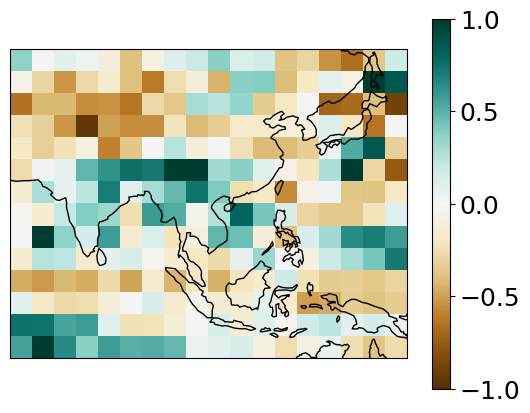

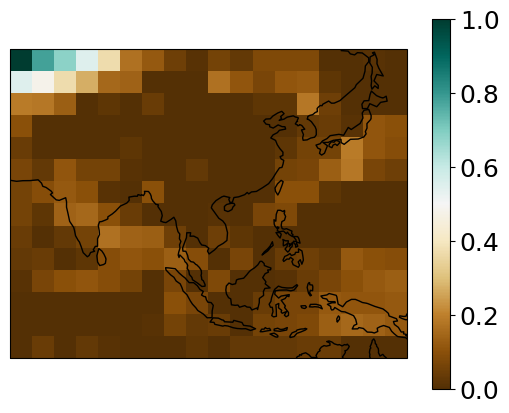

In [10]:
sandbox = monsoon_coarse[0]
sand = monsoon_coarse[0, 0]
show_prcp(sand)
correlationcheck(sandbox)

In [11]:
def make_mask(index_point, sample, threshold):
    threshold = threshold # correlation
    
    point_num = index_point
    comp_num = 252
    
    sample_num = 165
    x_length = 18
    y_length = 14
    
    sample = sample.reshape(sample_num, y_length, x_length)
    sample = sample.reshape(sample_num, y_length*x_length)
    
    point = sample[:, index_point]

    corr = []
    for index_comp in range(comp_num):
        comp = sample[:, index_comp]
        rr = np.corrcoef(point, comp)
        score = np.round(rr[0, 1], 2)
        corr.append(score)

    corr = np.array(corr)
    mask = corr >= threshold
    return mask

def correlation_clustering(sample, initial_index=0, threshold=0.6):
    """
    sample.shape = 165, 14, 18
    165サンプルをつかって2グリッド(point, comp)の相関を調べる
    
    x_index = [0...17]
    y_index = [0...13]
    """
    x_length = 18
    y_length = 14
    
    ###################################### storing cluster coordinates ##################
    # initial criteria point
    index_point = initial_index 
    
    # initialization
    clst_coor = []
    clst_coor.append(index_point)
    done_lst = []
    
    while all(np.sort(done_lst) != np.sort(clst_coor)):
        for index_point in clst_coor:
            if index_point not in done_lst:
                mask = make_mask(index_point, sample, threshold)

                # coordinate transformation
                x_index = index_point % x_length
                y_index = index_point // x_length

                # left
                if x_index != 0:
                    temp_x = x_index - 1
                    flat_index = x_length*y_index + temp_x
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: left")

               # right
                if x_index != (x_length - 1):
                    temp_x = x_index + 1
                    flat_index = x_length*y_index + temp_x
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: right")

                # up
                elif y_index != 0:
                    temp_y = y_index - 1
                    flat_index = x_length*temp_y + x_index
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: up")

                # down
                if y_index != (y_length - 1):
                    temp_y = y_index + 1
                    flat_index = x_length*temp_y + x_index
                    if mask[flat_index] and flat_index not in clst_coor:
                        clst_coor.append(flat_index)
                        #print(f"flat_index: {flat_index}, direction: down")

                done_lst.append(index_point)
            else:
                print(f"index_point {index_point} is already in done_lst")
        
    return clst_coor

def reduce_cluster(sorted_cluster, cluster_num=3):
    """
    cluster_num: number of grids in one cluster
    """
    # unique selection
    unique_cluster = []
    seen_rows = set()

    for row in sorted_cluster:
        sorted_row = np.sort(row)
        row_tuple = tuple(sorted_row)
        if row_tuple not in seen_rows:
            unique_cluster.append(sorted_row)
            seen_rows.add(row_tuple)
            #print(sorted_row)

    #print(f"number of cluster {len(unique_cluster)}")
    
    # reduce by cluster_num
    reduced_cluster = []
    for i in range(len(unique_cluster)):
        if len(unique_cluster[i]) >= cluster_num:
             reduced_cluster.append(unique_cluster[i])
                
    # overlapped grid
    overlapped = []
    for list_a in reduced_cluster:
        candidate = []
        candidate_len = []
        for list_b in reduced_cluster:
            if any(item in list_a for item in list_b):
                candidate.append(list_b)
                candidate_len.append(len(list_b))
        arr = np.array(candidate_len)
        index = np.argmax(arr)
        overlapped.append(candidate[index])
    
    # unique selection
    unique_cluster = []
    seen_rows = set()

    for row in overlapped:
        sorted_row = np.sort(row)
        row_tuple = tuple(sorted_row)
        if row_tuple not in seen_rows:
            unique_cluster.append(sorted_row)
            seen_rows.add(row_tuple)
        
    return unique_cluster

def show_cluster(cluster_list):
    x_length = 18
    y_length = 14
    mask_image = np.zeros((y_length*x_length))
    for label, cluster_mask in enumerate(cluster_list):
        for index in cluster_mask:
            mask_image[index] = label+1
    mask_image = np.reshape(mask_image, (y_length, x_length))
    
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(mask_image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap = 'Blues',
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()

def show_individual_cluster(cluster_mask):
    x_length = 18
    y_length = 14
    mask_image = np.zeros((y_length*x_length))
    for i in cluster_mask:
        mask_image[i] = 1
    mask_image = np.reshape(mask_image, (y_length, x_length))
    
    plt.rcParams["font.size"] = 18
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-120, -30, -15, 55)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(mask_image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap = 'Blues',
                    )
    cbar = fig.colorbar(mat, ax=ax)
    plt.show()
    
def show_timeseriese(data, index_list):
    data = np.reshape(data, (165, 14*18))
    
    fig, ax = plt.subplots(figsize=(18, 8))
    plt.subplots_adjust(hspace=0.5)
    
    ts_cluster = []

    for grid in index_list:
        ts_cluster.append(data[:, grid])
        ax.plot(data[:, grid], "k-", alpha=.05)

    ts_arr = np.array(ts_cluster)
    ts_mean = np.mean(ts_cluster, axis=0)
    ax.plot(ts_mean, "r-")
    
    plt.show()

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 0
threshold: 0.5, cluster_num: 2, result: 16


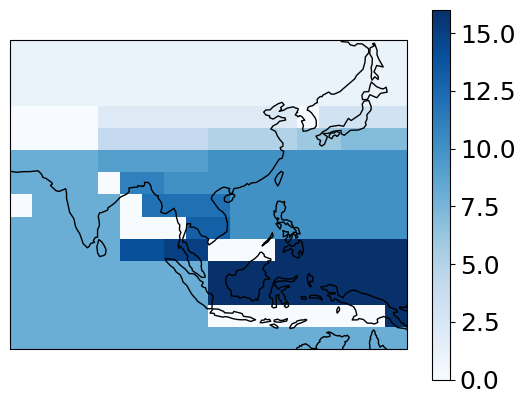

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 1
threshold: 0.5, cluster_num: 2, result: 18


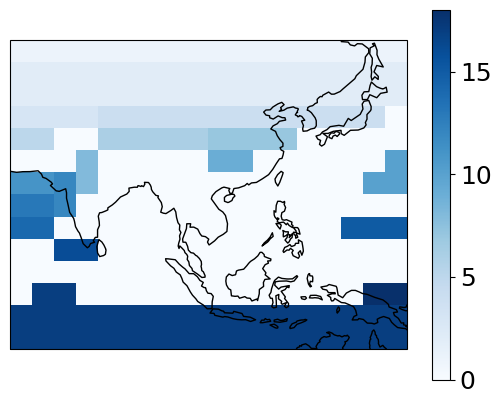

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 2
threshold: 0.5, cluster_num: 2, result: 13


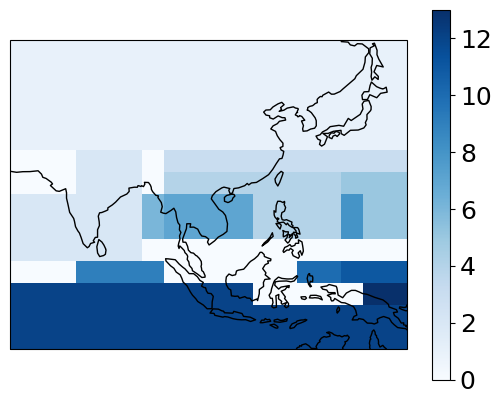

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 3
threshold: 0.5, cluster_num: 2, result: 17


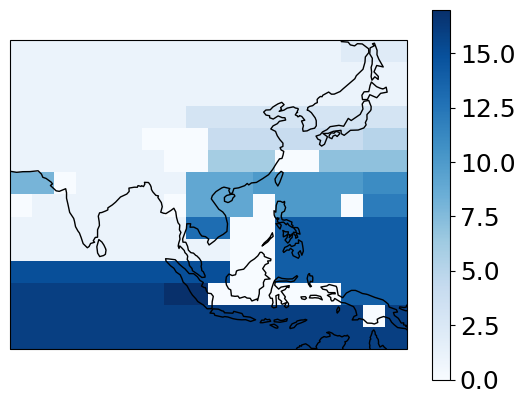

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 4
threshold: 0.5, cluster_num: 2, result: 16


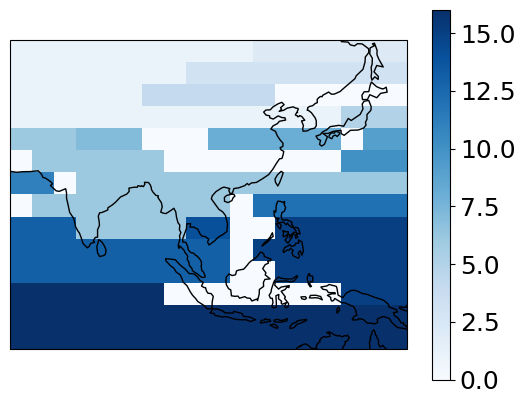

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 5
threshold: 0.5, cluster_num: 2, result: 28


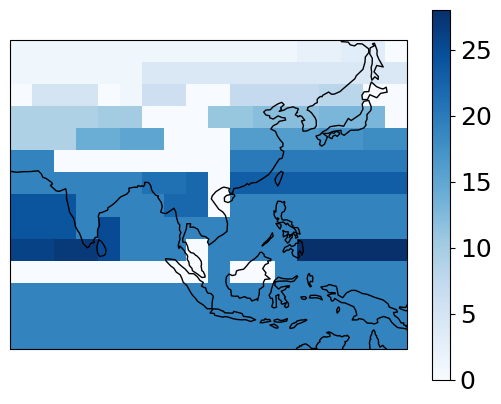

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 6
threshold: 0.5, cluster_num: 2, result: 22


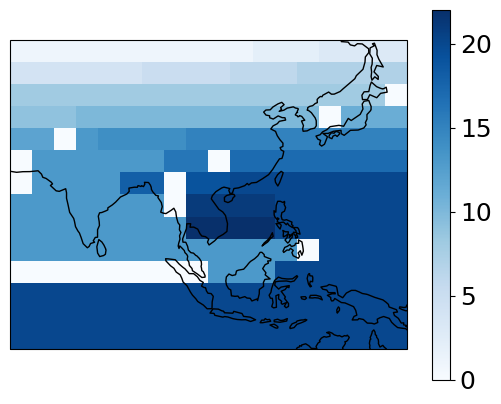

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 7
threshold: 0.5, cluster_num: 2, result: 4


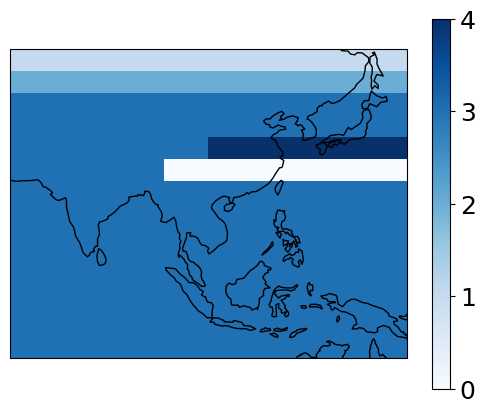

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 8
threshold: 0.5, cluster_num: 2, result: 20


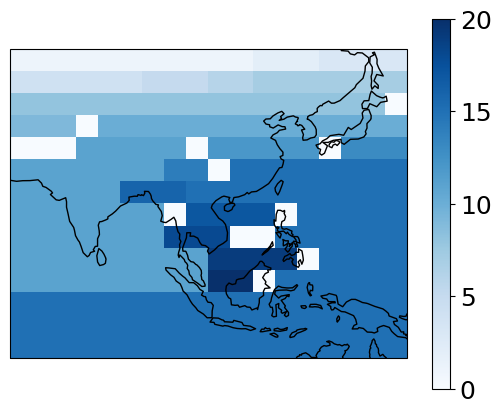

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 9
threshold: 0.5, cluster_num: 2, result: 34


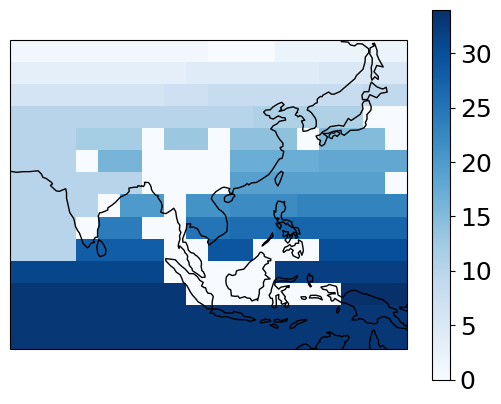

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 10
threshold: 0.5, cluster_num: 2, result: 16


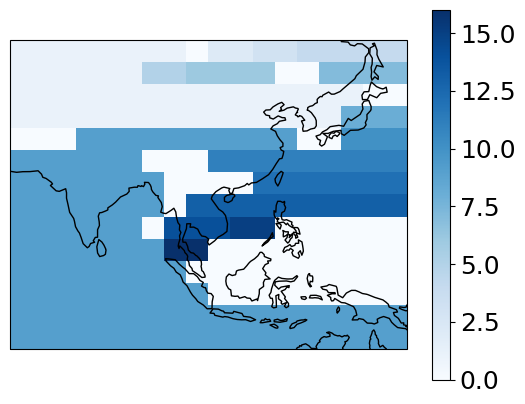

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 11
threshold: 0.5, cluster_num: 2, result: 23


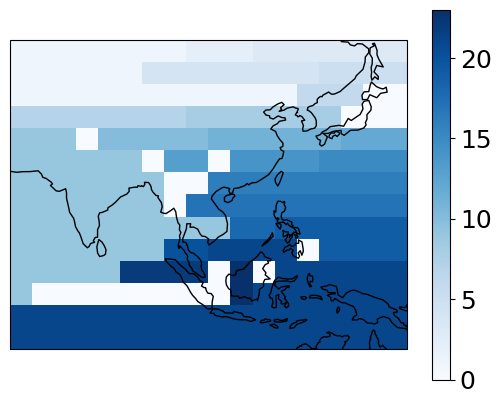

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 12
threshold: 0.5, cluster_num: 2, result: 34


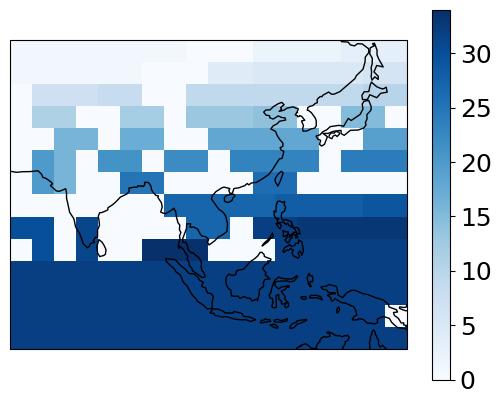

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 13
threshold: 0.5, cluster_num: 2, result: 24


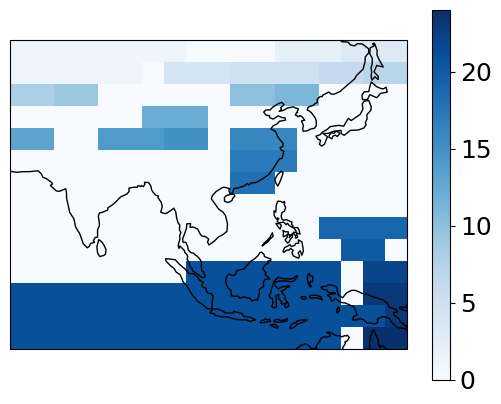

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 14
threshold: 0.5, cluster_num: 2, result: 33


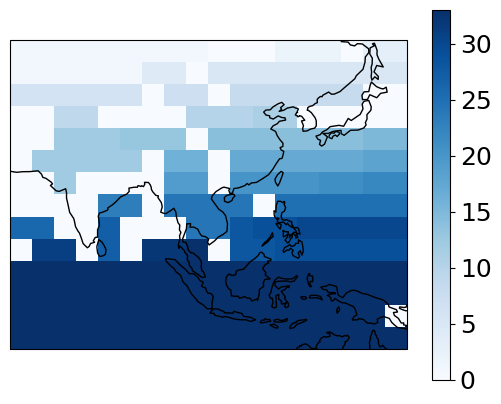

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 15
threshold: 0.5, cluster_num: 2, result: 25


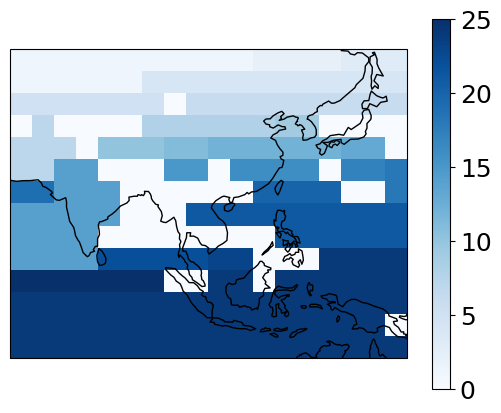

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 16
threshold: 0.5, cluster_num: 2, result: 18


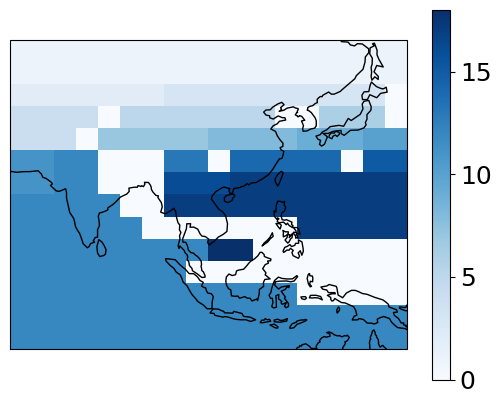

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 17
threshold: 0.5, cluster_num: 2, result: 30


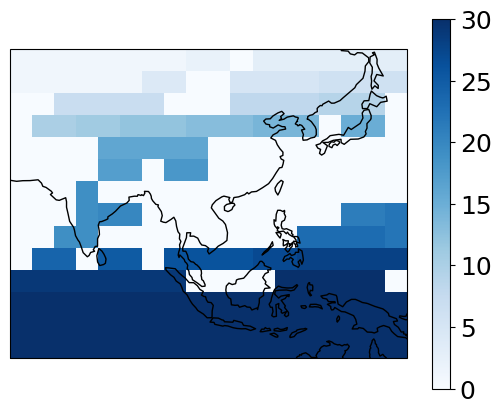

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 18
threshold: 0.5, cluster_num: 2, result: 22


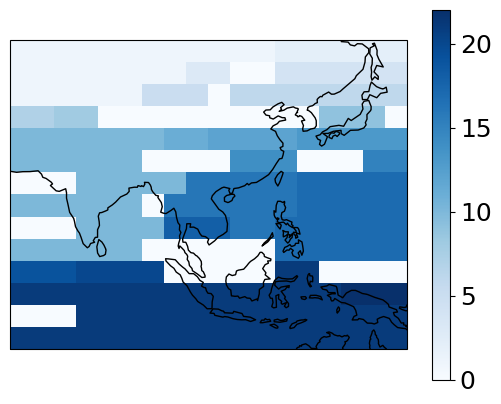

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 19
threshold: 0.5, cluster_num: 2, result: 10


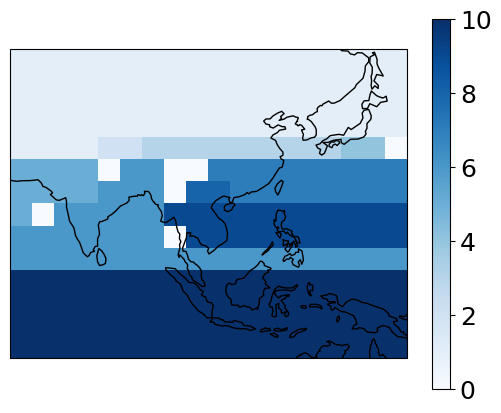

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 20
threshold: 0.5, cluster_num: 2, result: 9


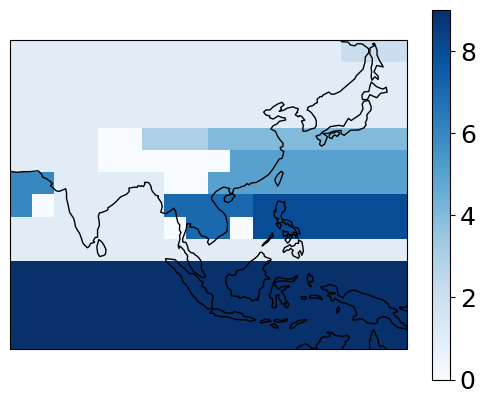

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 21
threshold: 0.5, cluster_num: 2, result: 10


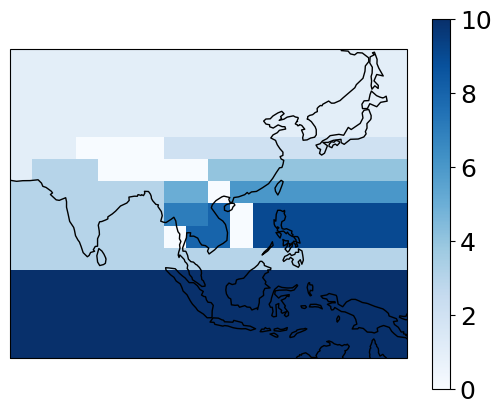

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 22
threshold: 0.5, cluster_num: 2, result: 9


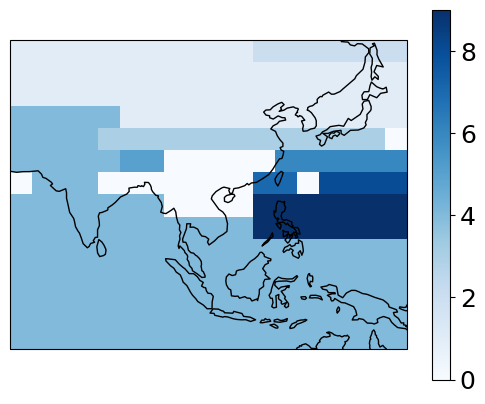

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 23
threshold: 0.5, cluster_num: 2, result: 11


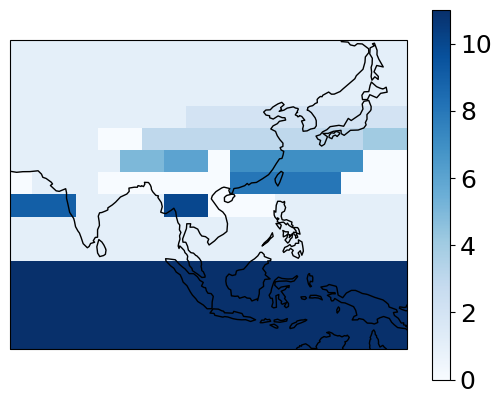

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 24
threshold: 0.5, cluster_num: 2, result: 27


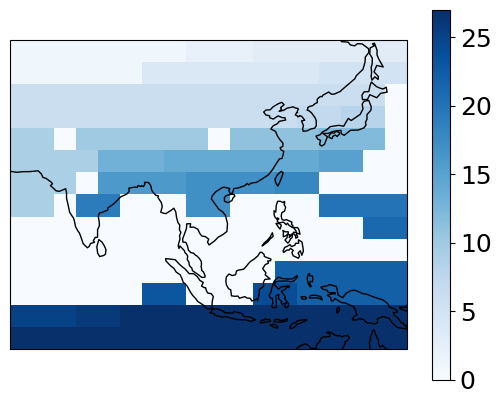

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 25
threshold: 0.5, cluster_num: 2, result: 22


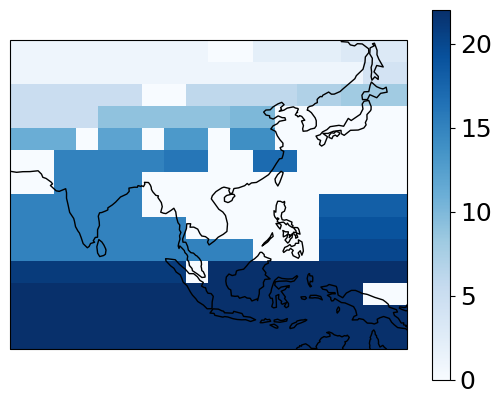

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 26
threshold: 0.5, cluster_num: 2, result: 25


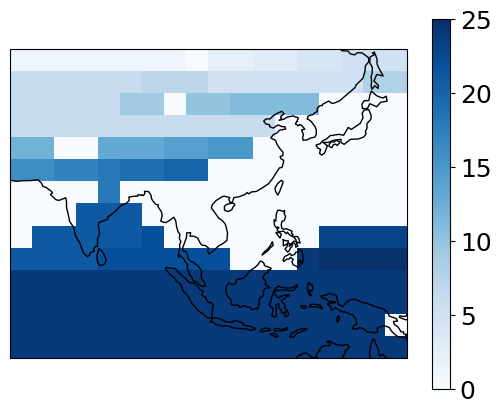

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 27
threshold: 0.5, cluster_num: 2, result: 34


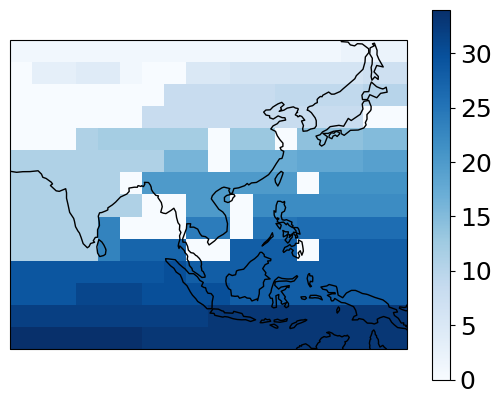

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 28
threshold: 0.5, cluster_num: 2, result: 12


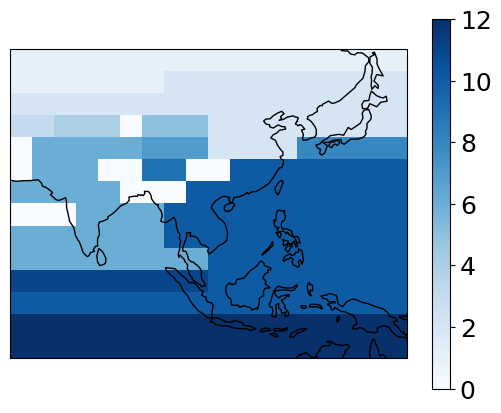

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 29
threshold: 0.5, cluster_num: 2, result: 23


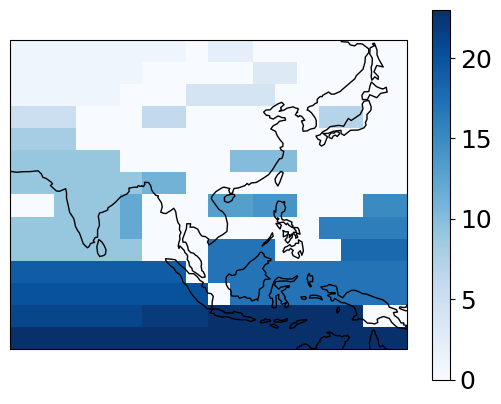

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 30
threshold: 0.5, cluster_num: 2, result: 28


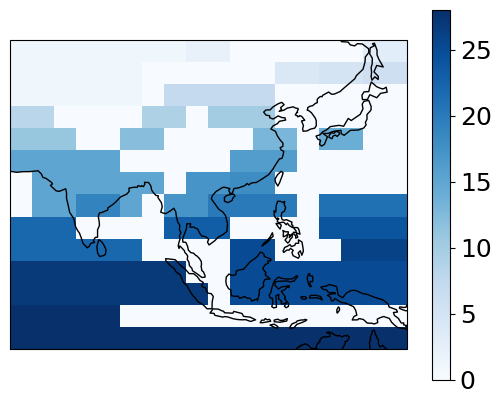

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 31
threshold: 0.5, cluster_num: 2, result: 31


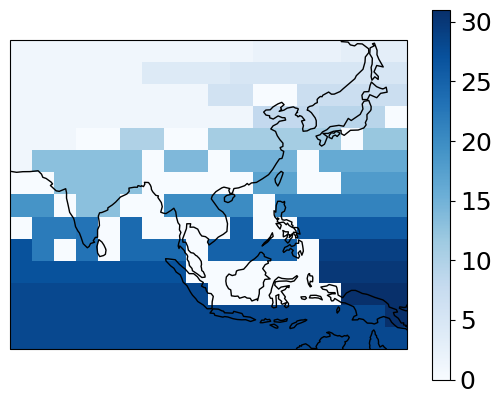

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 32
threshold: 0.5, cluster_num: 2, result: 26


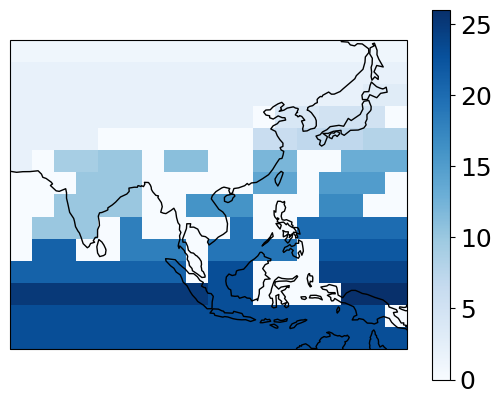

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 33
threshold: 0.5, cluster_num: 2, result: 6


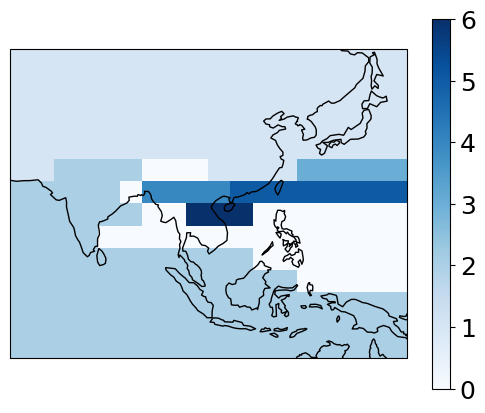

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 34
threshold: 0.5, cluster_num: 2, result: 8


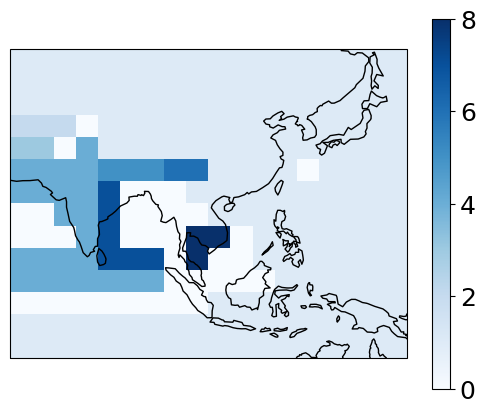

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 35
threshold: 0.5, cluster_num: 2, result: 29


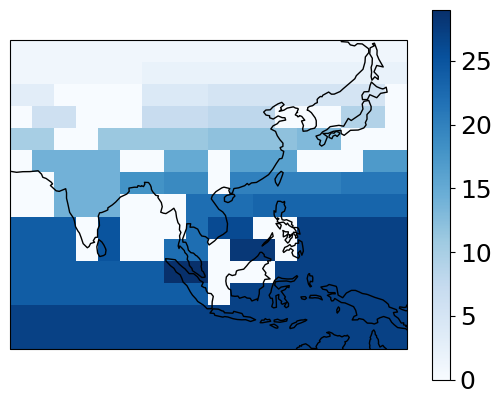

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 36
threshold: 0.5, cluster_num: 2, result: 15


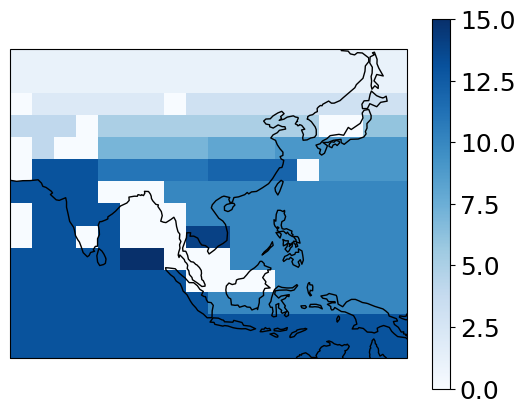

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 37
threshold: 0.5, cluster_num: 2, result: 28


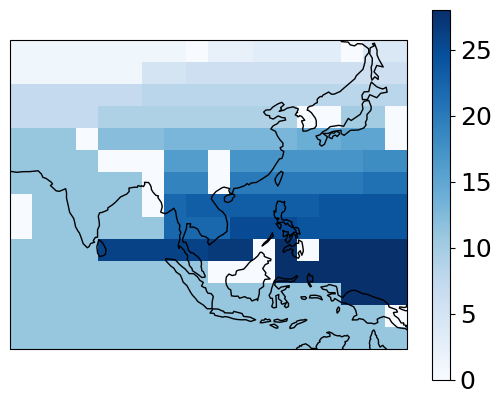

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 38
threshold: 0.5, cluster_num: 2, result: 17


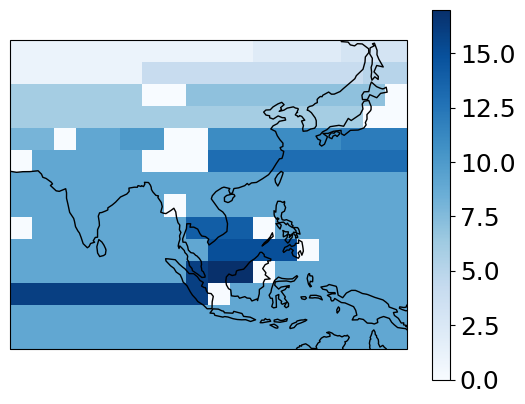

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 39
threshold: 0.5, cluster_num: 2, result: 26


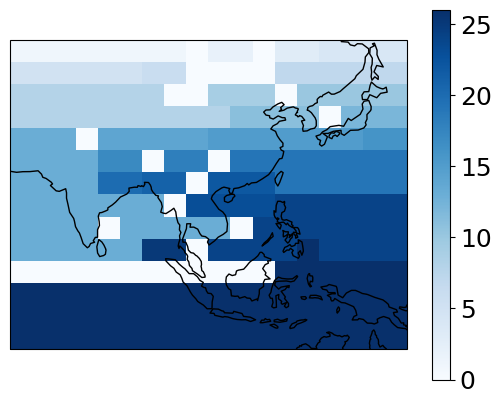

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 40
threshold: 0.5, cluster_num: 2, result: 25


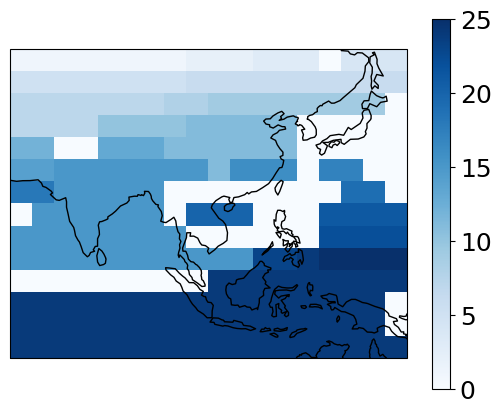

initial index 0 is done
initial index 50 is done
initial index 100 is done
initial index 150 is done
initial index 200 is done
initial index 250 is done
model index: 41
threshold: 0.5, cluster_num: 2, result: 25


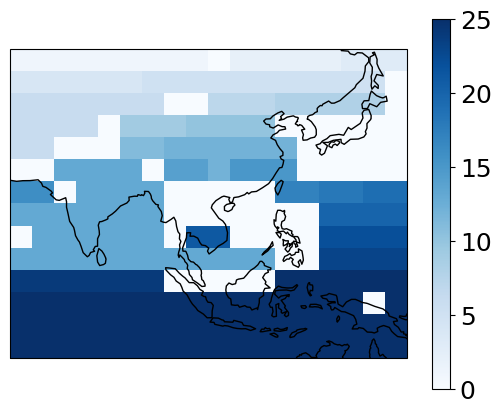

In [12]:
for model in range(42):
    awi = monsoon_coarse[model]
    
    threshold = 0.5
    cluster_num = 2
    cluster = []
    
    for i in range(14*18):
        cluster_grid = correlation_clustering(awi, initial_index=i, threshold=threshold)
        cluster.append(cluster_grid)
        if i%50 == 0:
            print(f"initial index {i} is done")
    reduced_cluster = reduce_cluster(cluster, cluster_num=cluster_num)
    print(f"model index: {model}")
    print(f"threshold: {threshold}, cluster_num: {cluster_num}, result: {len(reduced_cluster)}")
    show_cluster(reduced_cluster)